# Interpretability experiments Language Identification Task

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import sys
sys.path.append('/content/utils.py')

In [6]:
from utils import (
    load_model,
    data_loaders_and_vocab_multilingual,
    load_multilingual_model
)
import os
import json
import random
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from matplotlib.lines import Line2D

In [7]:
NUM_WORKERS = os.cpu_count()
print("Number of workers:", NUM_WORKERS)
print("Using torch", torch.__version__)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print ("CUDA device found.")
else:
   DEVICE = torch.device("cpu")
   print('No CUDA has been found. PyTorch will use CPU.')


Number of workers: 8
Using torch 2.6.0+cu124
CUDA device found.


In [8]:
base_dir = '/content/drive/MyDrive/MVA/NLP/AlgorithmsSpeechNLP'
monolingual_train_pairs = {
    'eng1': 'eng_mls',
    # 'eng2': 'eng_nchlt',
    # 'eng3': 'eng_voxpopuli',
    'fra1': 'fra_mls',
    # 'fra2': 'fra_voxpopuli',
    'deu1': 'deu_swc',
    # 'deu2': 'deu_voxpopuli',
    'rus': 'rus_M-AILABS',
    'swa': 'swa_ALFFA',
    'swe': 'swe_NST',
    'xty': 'xty_mexico-el'
}

In [9]:
# Load languages
with open(f'{base_dir}/ml_superb_dataset.json', 'r') as f:
    datasets = json.load(f)

print(f"Loaded {len(datasets)} language-source pairs")

Loaded 271 language-source pairs


In [10]:
model_name = "facebook/hubert-base-ls960"
upstream_model, feature_extractor = load_model(model_name, device=DEVICE)

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

In [11]:
train_loader, val_loader, test_loader, char_mappings, language_mapping = data_loaders_and_vocab_multilingual(datasets, feature_extractor, num_samples=50)

In [12]:
task = "lid"
model_path = os.path.join(base_dir, "reproduced_models/hubert_base/multilingual/hubert-base-ls960_multilingual_lid.pt")
multilingual_model = load_multilingual_model(task, upstream_model, len(char_mappings['char_to_idx']), len(language_mapping["idx_to_lang"].keys()), model_path)

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

In [13]:
task = "asr+lid"
model_path = os.path.join(base_dir, "reproduced_models/hubert_base/multilingual/hubert-base-ls960_multilingual_asr+lid.pt")
multilingual_model_w_asr = load_multilingual_model(task, upstream_model, len(char_mappings['char_to_idx']), len(language_mapping["idx_to_lang"].keys()), model_path)

## T-SNE

In [14]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from matplotlib.lines import Line2D

def extract_features_tsne_projection(model, test_loader, max_batches=None, device=DEVICE):
    """
    Processes multiple batches from test_loader, accumulates the upstream representations,
    transformer layer outputs, output layer logits, ground-truth language IDs, and prediction correctness.
    Computes t-SNE projections for the upstream, transformer features, and output logits.

    Args:
        model: The downstream model with a frozen upstream module.
        test_loader: DataLoader that yields batches with keys 'input_values', 'lang_ids', etc.
        max_batches: Optional maximum number of batches to process.
        device: Device to perform computation on.

    Returns:
        upstream_tsne: t-SNE projection (2D) of the upstream representation.
        transformer_tsnes: List of t-SNE projections for each transformer layer.
        lid_tsne: t-SNE projection (2D) of the output layer logits.
        lang_ids_all: Ground-truth language IDs for all examples (NumPy array).
        correct_all: Boolean array indicating if each sample was correctly identified.
    """
    model.eval()
    upstream_features_list = []
    transformer_features_list = None  # List of lists (one per transformer layer)
    lang_ids_list = []
    correct_list = []
    lid_logits_list = []
    batch_count = 0
    with torch.no_grad():
        for batch in test_loader:
            input_values = batch['input_values'].to(device)
            lang_ids = batch['lang_ids'].to(device)  # Ground-truth language IDs

            # Upstream Representation
            outputs = model.upstream_model(
                input_values,
                output_hidden_states=True,
                return_dict=True
            )
            hidden_states = outputs.hidden_states[1:]  # Skip the first state

            # Compute weighted sum of hidden states.
            weighted_sum = torch.zeros_like(hidden_states[0])
            for i, h in enumerate(hidden_states):
                weighted_sum += model.layer_weights[i] * h

            # Convolutional downsampling.
            x = weighted_sum.transpose(1, 2)
            x = model.conv_downsample(x)
            x = x.transpose(1, 2)  # Back to [batch, sequence_length, hidden_size]

            # Upstream representation: average pool over time.
            upstream_rep = x.mean(dim=1)  # shape: [batch, hidden_size]
            upstream_features_list.append(upstream_rep)

            # Transformer Layers
            if transformer_features_list is None:
                transformer_features_list = [[] for _ in range(len(model.transformer.layers))]

            x_input = x  # Input for transformer layers.
            for idx, layer in enumerate(model.transformer.layers):
                x_input = layer(x_input)
                x_mean = x_input.mean(dim=1)  # Mean pool
                transformer_features_list[idx].append(x_mean)

            # Prediction / Output Layer
            pooled = x_input.mean(dim=1)  # Final pooled representation
            lid_logits = model.lid_classifier(pooled)
            lid_logits_list.append(lid_logits)

            lid_predictions = torch.argmax(lid_logits, dim=1)
            correct = (lid_predictions == lang_ids)
            correct_list.append(correct)

            # Collect language IDs
            lang_ids_list.append(lang_ids)

            batch_count += 1
            if max_batches is not None and batch_count >= max_batches:
                break

    # Concatenate features and labels
    upstream_features = torch.cat(upstream_features_list, dim=0)  # [N, hidden_size]
    transformer_features = [torch.cat(lst, dim=0) for lst in transformer_features_list]
    lid_logits_all = torch.cat(lid_logits_list, dim=0)
    lang_ids_all = torch.cat(lang_ids_list, dim=0)
    correct_all = torch.cat(correct_list, dim=0)


    # Compute t-SNE projections
    upstream_tsne = TSNE(n_components=2, random_state=42, perplexity=10).fit_transform(upstream_features.cpu().numpy())

    transformer_tsnes = []
    for feats in transformer_features:
        tsne_proj = TSNE(n_components=2, random_state=42, perplexity=10).fit_transform(feats.cpu().numpy())
        transformer_tsnes.append(tsne_proj)

    lid_tsne = TSNE(n_components=2, random_state=42, perplexity=10).fit_transform(lid_logits_all.cpu().numpy())

    return upstream_tsne, transformer_tsnes, lid_tsne, lang_ids_all.cpu().numpy(), correct_all.cpu().numpy()


In [15]:
def plot_tsne(upstream_tsne,transformer_tsnes, lid_tsne, lang_ids, correct_flags):
    num_transformer_layers = len(transformer_tsnes)
    total_plots = 1 + num_transformer_layers + 1  # Upstream + Transformer layers + Output layer

    fig, axs = plt.subplots(1, total_plots, figsize=(5 * total_plots, 5))
    if total_plots == 1:
        axs = [axs]  # Ensure axs is iterable.

    def plot_with_correctness(ax, tsne_data, lang_ids, correct_flags):
        """
        Plots t-SNE data on the given axes, separating points by correctness.
        Points with correct predictions are drawn as circles ('o'),
        and incorrect ones as crosses ('x').
        """
        correct_idx = np.where(correct_flags)[0]
        incorrect_idx = np.where(~correct_flags)[0]

        unique_langs = sorted(np.unique(lang_ids_np))
        sc1 = ax.scatter(tsne_data[correct_idx, 0], tsne_data[correct_idx, 1],
                        c=lang_ids[correct_idx], cmap=plt.get_cmap('tab10', len(unique_langs)), marker='o', alpha=0.7)
        sc2 = ax.scatter(tsne_data[incorrect_idx, 0], tsne_data[incorrect_idx, 1],
                        c=lang_ids[incorrect_idx], cmap=plt.get_cmap('tab10', len(unique_langs)), marker='x', alpha=0.7)
        return sc1, sc2

    # Create legend elements
    legend_elements = [
        Line2D([0], [0], marker='o', label='Correct', markersize=10),
        Line2D([0], [0], marker='x', label='Incorrect', markersize=10)
    ]

    # Plot Upstream Representation
    sc1, sc2 = plot_with_correctness(axs[0], upstream_tsne, lang_ids_np, correct_np)
    axs[0].set_title("Upstream Model Output")
    axs[0].set_xlabel("t-SNE 1")
    axs[0].set_ylabel("t-SNE 2")
    #plt.colorbar(sc1, ax=axs[0], label="Language ID")
    #axs[0].legend(handles=legend_elements, loc='best')

    # Plot Transformer Layers
    for i, tsne_res in enumerate(transformer_tsnes):
        sc1, sc2 = plot_with_correctness(axs[i + 1], tsne_res, lang_ids_np, correct_np)
        axs[i + 1].set_title(f"Transformer Layer {i + 1}")
        axs[i + 1].set_xlabel("t-SNE 1")
        axs[i + 1].set_ylabel("t-SNE 2")
        #plt.colorbar(sc1, ax=axs[i + 1], label="Language ID")
        #axs[i + 1].legend(handles=legend_elements, loc='best')

    # Plot Output Layer (LID Logits)
    sc1, sc2 = plot_with_correctness(axs[-1], lid_tsne, lang_ids_np, correct_np)
    axs[-1].set_title("Output Layer (LID Logits)")
    axs[-1].set_xlabel("t-SNE 1")
    axs[-1].set_ylabel("t-SNE 2")

    cbar = plt.colorbar(sc1, ax=axs[-1], label="Language")
    cbar.set_ticks(list(language_mapping['idx_to_lang'].keys()))
    cbar.set_ticklabels([language_mapping['idx_to_lang'][i] for i in language_mapping['idx_to_lang'].keys()])
    axs[-1].legend(handles=legend_elements, loc='best')

    plt.tight_layout()
    plt.show()


### LID fine-tuned model

In [16]:
upstream_tsne, transformer_tsnes, lid_tsne, lang_ids_np, correct_np = extract_features_tsne_projection(
    multilingual_model, test_loader, max_batches=None, device=DEVICE
)

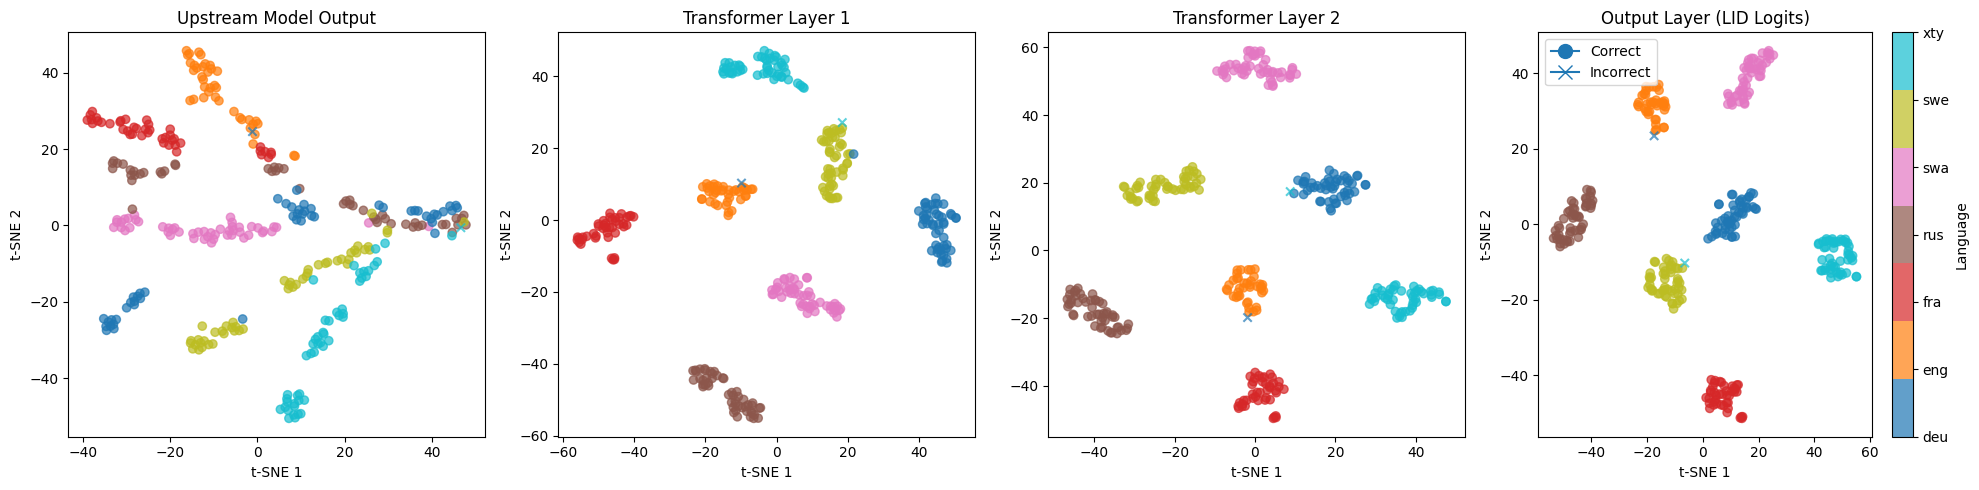

In [17]:
plot_tsne(upstream_tsne,transformer_tsnes, lid_tsne, lang_ids_np, correct_np)

### LID-ASR fine-tuned model

In [ ]:
upstream_tsne, transformer_tsnes, lid_tsne, lang_ids_np, correct_np = extract_features_tsne_projection(
    multilingual_model_w_asr, test_loader, max_batches=None, device=DEVICE
)

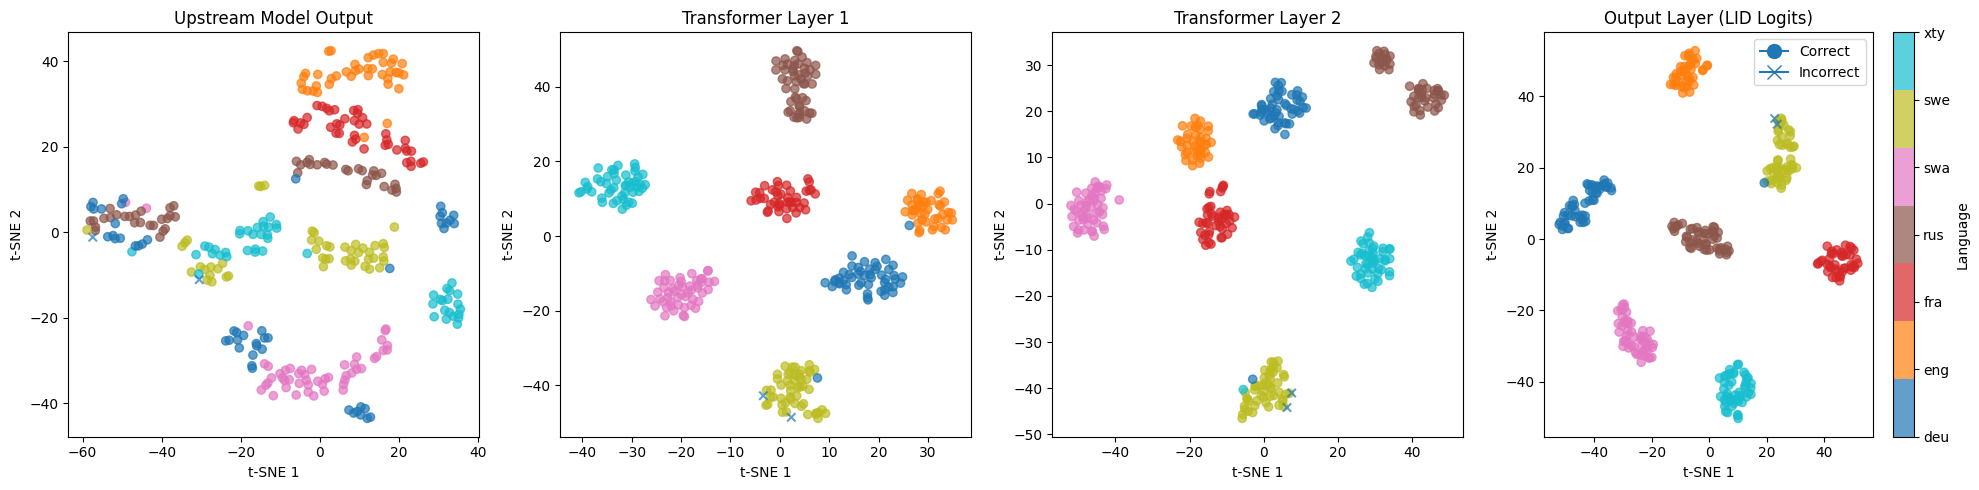

In [ ]:
plot_tsne(upstream_tsne,transformer_tsnes, lid_tsne, lang_ids_np, correct_np)